In [1]:
import re
from itertools import combinations
import warnings

import pandas as pd
import numpy as np

from google.cloud import storage
from io import BytesIO

from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import stem

from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.preprocessing import FunctionTransformer, scale
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, strip_tags
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
pd.set_option('max_colwidth', 100)
warnings.filterwarnings("ignore")
%matplotlib inline

Note per [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html): In Python 3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED environment variable to control hash randomization; you can set this when launching the notebook: `PYTHONHASHSEED=0 jupyter lab`

### Load "Fake News" dataset

Source: [https://www.kaggle.com/mrisdal/fake-news/data](https://www.kaggle.com/mrisdal/fake-news/data)

In [3]:
# load data
client = storage.Client.create_anonymous_client()
bucket = client.bucket('djr-data')

blob = bucket.blob('fake-news/fake.csv')
buf = BytesIO()
blob.download_to_file(buf)
buf.seek(0)
df = pd.read_csv(buf)
df.head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t Benefits,Print They should pay all the back all the money plus interest. The entire family and everyone w...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t Benefits,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fullscreen-capture-10262016-83501-AM.bmp.jpg,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Plead The Fifth?,Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The a...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Plead The Fifth?,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fullscreen-capture-10282016-102616-PM.bmp.jpg,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hillary Email Investigation,Red State : \nFox News Sunday reported this morning that Anthony Weiner is cooperating with the ...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hillary Email Investigation,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fullscreen-capture-10302016-60437-PM.bmp.jpg,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,"PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnapped And Killed By ISIS: ""I have voted for Donald J. ...",Email Kayla Mueller was a prisoner and tortured by ISIS while no chance of release…a horrific st...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,"PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnapped And Killed By ISIS: ""I have voted for Donald J. ...",0.068,http://100percentfedup.com/wp-content/uploads/2016/10/kayla.jpg,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com,"Email HEALTHCARE REFORM TO MAKE AMERICA GREAT AGAIN \nSince March of 2010, the American people h...",english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com,0.865,http://100percentfedup.com/wp-content/uploads/2016/11/obamacare-sites-404-970x0.jpg,0,0,0,0,0,bias


In [4]:
# a little cleanup
df = df.loc[(df.language == 'english') & (df.country == 'US'), :]

site_url_counts = df.site_url.value_counts()
top_sites = site_url_counts.index[site_url_counts == 100]
df = df.loc[df.site_url.isin(top_sites), :]

df.loc[~df.thread_title.isnull(), ['text']] = df.loc[~df.thread_title.isnull(), :].apply(lambda row: '{}. {}'.format(row['thread_title'], row['text']), axis=1)
df.drop_duplicates(subset=['text'], inplace=True)

df = df.loc[df.ord_in_thread == 0, :]

In [5]:
# in the interest of speed, train on a subset of articles stratified by source
df_train, df_holdout = train_test_split(df, train_size=2000, stratify=df.site_url, random_state=1)

### Make preprocessing pipelines

In [6]:
# return words from corpus; alternative token: r"([\w][\w']*\w)
def tokenize(doc, token=r"(?u)\b\w\w+\b"):
    doc = doc.lower()
    doc = strip_tags(doc)
    doc = re.compile(r"https?:\/\/(www\.)?([^\s]*)").sub("", doc)
    # doc = stem(doc)
    words = re.compile(token).findall(doc)
    words = [w for w in words if re.compile(r"[a-zA-Z]").findall(w)]
    return words

# remove stop words
def remove_stop_words(x, stop_words=ENGLISH_STOP_WORDS):
    return [i for i in x if i not in stop_words]

In [7]:
# wrapper for gensim Phraser
COMMON_TERMS = ["of", "with", "without", "and", "or", "the", "a"]
class PhraseTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, min_count, common_terms=COMMON_TERMS):
        self.phraser = None
        self.min_count = min_count
        self.common_terms = common_terms

    def fit(self, X, y=None):
        phrases = Phrases(X, min_count=self.min_count, common_terms=self.common_terms)
        self.phraser = Phraser(phrases)
        return self

    def transform(self, X):
        return X.apply(lambda x: self.phraser[x])

In [8]:
# make pipeline
MIN_DF = 10

preprocessing = Pipeline(steps=[
    ('tk', FunctionTransformer(func=lambda x: x.apply(tokenize), validate=False)),
    ('ph', PhraseTransformer(min_count=MIN_DF)),
    ('sw', FunctionTransformer(func=lambda x: x.apply(remove_stop_words), validate=False))
])

# NOTE: already tokenized so CountVectorizer effectively just converting to sparse matrix
preprocessing2 = Pipeline(steps=[
    ('pp', preprocessing),
    ('cv', CountVectorizer(min_df=MIN_DF, max_df=0.4, tokenizer=lambda x: x, lowercase=False)),
    ('tf', TfidfTransformer(use_idf=True)),
])

pipeline = Pipeline(steps=[
    ('pp', preprocessing2),
    ('tm', NMF(random_state=1, alpha=0, init='nndsvd', solver='mu', max_iter=1000))
])

### Build W2V model

This will be used to calculate similarities between words

In [9]:
%%time
sentences = preprocessing.fit_transform(df_train.text)
w2v = Word2Vec(sentences, min_count=MIN_DF, size=100, iter=10, seed=1, sg=1, window=10, workers=1)

CPU times: user 2min 31s, sys: 0 ns, total: 2min 31s
Wall time: 2min 32s


In [10]:
w2v.wv.most_similar(positive=['russia'])

[('putin', 0.7353851795196533),
 ('vladimir_putin', 0.7088087201118469),
 ('russian', 0.69211745262146),
 ('moscow', 0.6595130562782288),
 ('russian_president', 0.6588544249534607),
 ('against_russia', 0.6265290975570679),
 ('cyber_attacks', 0.6002523899078369),
 ('president_vladimir', 0.599993109703064),
 ('since_the_cold', 0.5986747145652771),
 ('russian_government', 0.5881158113479614)]

### Build topic model

NOTE: seeding number of topics at `(n*m)/t` where:
* m = number of documents
* n = number of terms
* t = number of non-zero entries in our document-term matrix 

In [11]:
# guess for number of topics we should start with
features = preprocessing2.fit_transform(df_train.text)
num_topics_seed = round(np.product(features.shape) / len(features.indices) / 10) * 10
num_topics_range = np.arange(10, num_topics_seed + 30, 10)

In [12]:
# top words for each topic
def top_keywords(weights, names, cutoff=0, top=10):
    weights = np.where(weights >= cutoff, weights, 0)
    names2, weights2 = names[np.nonzero(weights)], weights[np.nonzero(weights)]
    return [(names2[i], weights2[i]) for i in weights2.argsort()[:-top-1:-1]]

# build topic model with a specified number of topics
def build_topic_model(n):
    topic_model_i = clone(pipeline)
    topic_model_i.set_params(**{'tm__n_components': int(n)})
    
    W = topic_model_i.fit_transform(df_train.text)
    H = topic_model_i.named_steps['tm'].components_
    feature_names = np.array(topic_model_i.named_steps['pp'].named_steps['cv'].get_feature_names())
    topic_keywords = [top_keywords(h, feature_names) for h in H]
  
    return n, topic_model_i, W, topic_keywords

In [13]:
%%time
# build models for different numbers of topics
topic_models = [build_topic_model(i) for i in num_topics_range]

CPU times: user 6min 27s, sys: 2min 5s, total: 8min 33s
Wall time: 5min 38s


In [14]:
# calculate cohesiveness of a topic's keywords using word2vec model
def get_topic_cohesiveness(words, w2v_model, weight=True):
    pair_scores = []
    pair_weights = []
    if len(words) <= 1:
        return 0
    for p1, p2 in combinations(words, 2):
        pair_scores.append(w2v_model.wv.similarity(p1[0], p2[0]))
        if weight:
            pair_weights.append(p1[1] * p2[1])
        else:
            pair_weights.append(1.0)
    return np.sum(np.array(pair_scores) * np.array(pair_weights)) / np.sum(pair_weights)

# calculate cohesiveness of all topics
def get_cohesiveness(topic_keywords, w2v_model, topic_weights=None):
    if topic_weights is not None:
        topic_weights = np.ones(len(topic_keywords))   
    topic_cohesiveness = [get_topic_cohesiveness(kw, w2v_model) for kw in topic_keywords]
    return np.average(topic_cohesiveness, weights=topic_weights)

# get jaccard similarity between two topics
def get_jaccard(w1, w2):
    intersection = len(set.intersection(*[set(w1), set(w2)]))
    union = len(set.union(*[set(w1), set(w2)]))
    return intersection / float(union)    

# calculate model generality
get_first = lambda x: [i[0] for i in x]

def get_generality(topic_keywords, topic_weights=None):
    if topic_weights is not None:
        topic_weights = np.ones(len(topic_keywords))   
    pair_scores = []
    pair_weights = []
    for w1, w2 in combinations(zip(topic_keywords, topic_weights), 2):     
        pair_scores.append(get_jaccard(get_first(w1[0]), get_first(w2[0])))
        pair_weights.append(w1[1] * w2[1])
    return np.sum(np.array(pair_scores) * np.array(pair_weights)) / np.sum(pair_weights)

In [15]:
# calculate cohesiveness and generality
topic_weight = lambda W: np.apply_along_axis(np.sum, 0, W) / np.sum(W)

all_cohesiveness = [get_cohesiveness(t[-1], w2v, topic_weight(t[-2])) for t in topic_models]
all_generality = [get_generality(t[-1], topic_weight(t[-2])) for t in topic_models]
all_score = 0.7*scale(all_cohesiveness) - 0.3*scale(all_generality)

best_model_idx = np.argmax(all_score)
num_topic, topic_model, topic_matrix, topic_keywords = topic_models[best_model_idx]  

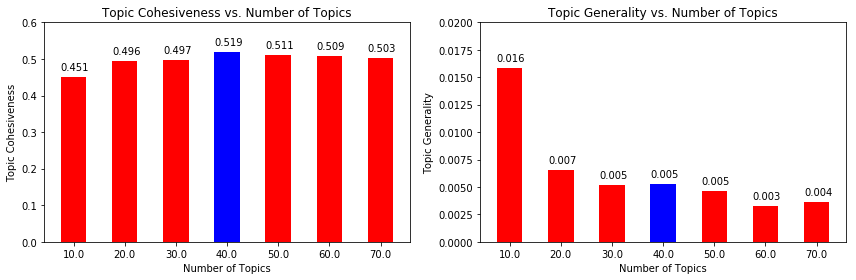

In [16]:
# plot cohesiveness and generality
width = 0.5
index = np.arange(len(num_topics_range))
padding = 0.03

def make_plot(data, title, ylim=(0, 1)):
    plt.title('Topic {} vs. Number of Topics'.format(title))
    plt.bar(index, data, width, color='red')
    plt.bar(best_model_idx, data[best_model_idx], width, color='blue')
    plt.ylim(ylim)
    for x, y in zip(index, data):
        plt.text(x - width/2, y + plt.gca().get_ylim()[1] * padding, "{:0.3f}".format(y))
    plt.xlabel('Number of Topics')
    plt.ylabel('Topic {}'.format(title))
    plt.xticks(index, num_topics_range)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
make_plot(all_cohesiveness, 'Cohesiveness', (0, 0.6))
plt.subplot(1, 2, 2)
make_plot(all_generality, 'Generality', (0, 0.02))
plt.tight_layout()
plt.show()

In [17]:
print("Optimal number of topics: {}".format(num_topic))

Optimal number of topics: 40.0


### Assign topics to articles

In [18]:
# top examples for each topic
topic_keywords2 = [[j[0] for j in i[0:5]] for i in topic_keywords]

topic_matrix_df = pd.DataFrame(topic_matrix)
df_train['topic'], df_train['topic_weight'] = zip(*topic_matrix_df.apply(lambda x: (np.argmax(x), np.max(x)), axis=1))

top_examples = df_train.sort_values(by=['topic', 'topic_weight'], ascending=False)
top_examples = top_examples.groupby(['topic'], as_index=False).first().loc[:, ['topic', 'title']]
top_examples['tags'] = topic_keywords2
top_examples

,topic,title,tags
0,0,Self-Help and the War on Common Sense,"[world, make, way, if_you, new]"
1,1,Shocking Development: FBI Re-Opens Probe Into Hillary Clinton Emails: “Perhaps Finally Justice W...,"[fbi, comey, investigation, clinton, emails]"
2,2,"Trump Busted For Flat Out Financially Scamming His Donors, Campaign Goes Into Last Minute Freefall","[trump, donald_trump, campaign, rally, media]"
3,3,Clinton’s Policy On Syria Will Lead To WW3 Says Trump,"[syria, russia, war, assad, no_fly]"
4,4,The “Dark Side” of the Mandelbrot Set [VIDEO],"[galacticconnection_com, click_here, psychic_protection, your_name, excerpts_may]"
5,5,Hillary Clinton is an alcoholic,"[hillary, clinton, hillary_clinton, campaign, clintons]"
6,6,Iraqi Troops in Mosul Could be Trump's First Crisis,"[mosul, isis, iraqi, forces, city]"
7,7,Election 2016 Current Votes in 8 Battleground States,"[percent, clinton, poll, voters, data]"
8,8,“I’m a Hispanic woman and I am voting for Donald Trump”,"[subscribe, email, email_address, blog, posts]"
9,9,Imam Mahdi And World War 3,"[facebook_comments, world_war, conversation, add, source]"


In [19]:
# assign each article to one or more topics
topic_assignment_cutoff = np.percentile(np.apply_along_axis(np.max, 1, topic_matrix), 10)
topic_assign = lambda x: np.where(x > topic_assignment_cutoff)[0].tolist()
flatten = lambda x: [item for sublist in x for item in sublist]

topic_matrix_assign = topic_matrix_df.apply(topic_assign, axis=1)
topics = flatten(topic_matrix_assign)
topic_counts = pd.Series(topics).value_counts() / len(topic_matrix)

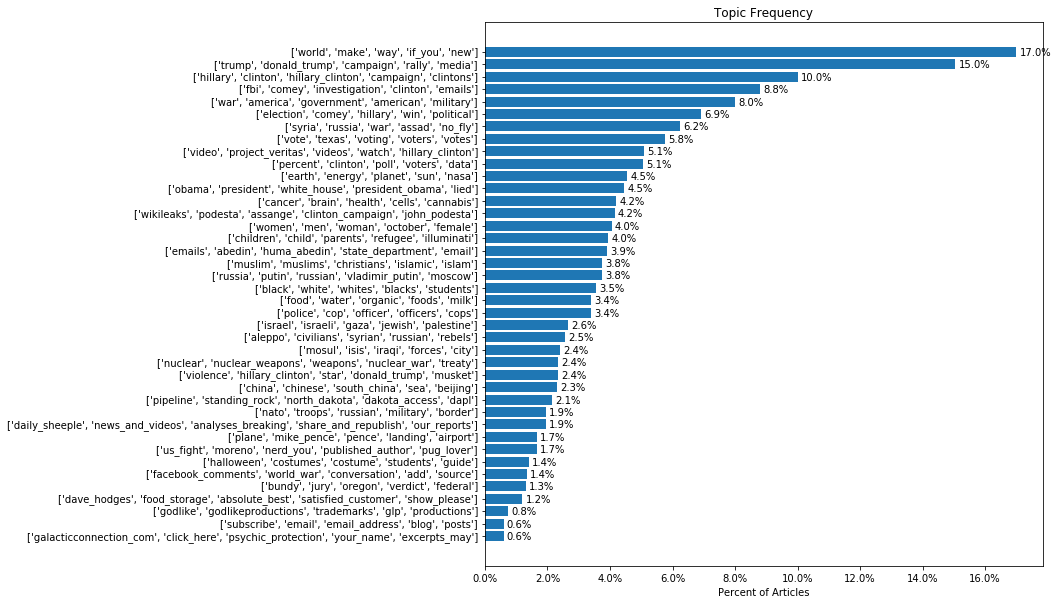

In [20]:
# topic tornado plot
index = np.arange(len(topic_counts))[::-1]
plt.figure(figsize=(10, 10))
plt.title('Topic Frequency')
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.barh(index, topic_counts, height=0.8)
for y, x in zip(index, topic_counts):
    plt.text(x + 0.001, y, "{:0.1f}%".format(x*100), verticalalignment='center')
plt.yticks(index, [topic_keywords2[i] for i in topic_counts.index], verticalalignment='center')
plt.xlabel('Percent of Articles')
plt.show()